In [1]:
import pyspark.sql.functions as F
from pyspark.sql.functions import pandas_udf, PandasUDFType, udf, broadcast, StringType
from pyspark.sql.types import IntegerType, BinaryType, ArrayType, BooleanType

from astropy.coordinates import SkyCoord
from astropy import units as u

import matplotlib.pylab as plt
import pandas as pd
import numpy as np
import glob

from fink_filters.ztf.classification import extract_fink_classification
from fink_utils.spark.utils import concat_col
from fink_science.ztf.xmatch.processor import crossmatch_other_catalog

/opt/spark-3/python/pyspark/sql/pandas/functions.py:399: UserWarning: In Python 3.6+ and Spark 3.0+, it is preferred to specify type hints for pandas UDF instead of specifying pandas UDF type which will be deprecated in the future releases. See SPARK-28264 for more details.
  warnings.warn(


In [2]:
# taken from https://github.com/astrolabsoftware/fink-science-portal/blob/b7326ed4febe0e106c1e93565ea622c1c95218e8/assets/spark_ztf_transfer.py#L112C1-L202C14
# on 19 FEB 2024
def add_classification(spark, df, path_to_tns):
    """ Add classification from Fink & TNS

    Parameters
    ----------
    spark:
    df: DataFrame
        Spark DataFrame containing ZTF alert data
    path_to_tns: str
        Path to TNS data (parquet)

    Returns
    ----------
    df: DataFrame
        Input DataFrame with 2 new columns `finkclass` and
        `tnsclass` containing classification tags.
    """
    # extract Fink classification
    df = df.withColumn(
        'finkclass',
        extract_fink_classification(
            df['cdsxmatch'],
            df['roid'],
            df['mulens'],
            df['snn_snia_vs_nonia'],
            df['snn_sn_vs_all'],
            df['rf_snia_vs_nonia'],
            df['candidate.ndethist'],
            df['candidate.drb'],
            df['candidate.classtar'],
            df['candidate.jd'],
            df['candidate.jdstarthist'],
            df['rf_kn_vs_nonkn'],
            df['tracklet']
        )
    )

    pdf_tns_filt = pd.read_parquet(path_to_tns)
    pdf_tns_filt_b = spark.sparkContext.broadcast(pdf_tns_filt)

    @pandas_udf(StringType(), PandasUDFType.SCALAR)
    def crossmatch_with_tns(objectid, ra, dec):
        # TNS
        pdf = pdf_tns_filt_b.value
        ra2, dec2, type2 = pdf['ra'], pdf['declination'], pdf['type']

        # create catalogs
        catalog_ztf = SkyCoord(
            ra=np.array(ra, dtype=np.float) * u.degree,
            dec=np.array(dec, dtype=np.float) * u.degree
        )
        catalog_tns = SkyCoord(
            ra=np.array(ra2, dtype=np.float) * u.degree,
            dec=np.array(dec2, dtype=np.float) * u.degree
        )

        # cross-match
        idx, d2d, d3d = catalog_tns.match_to_catalog_sky(catalog_ztf)

        sub_pdf = pd.DataFrame({
            'objectId': objectid.values,
            'ra': ra.values,
            'dec': dec.values,
        })

        # cross-match
        idx2, d2d2, d3d2 = catalog_ztf.match_to_catalog_sky(catalog_tns)

        # set separation length
        sep_constraint2 = d2d2.degree < 1.5 / 3600

        sub_pdf['TNS'] = ['Unknown'] * len(sub_pdf)
        sub_pdf['TNS'][sep_constraint2] = type2.values[idx2[sep_constraint2]]

        to_return = objectid.apply(
            lambda x: 'Unknown' if x not in sub_pdf['objectId'].values
            else sub_pdf['TNS'][sub_pdf['objectId'] == x].values[0]
        )

        return to_return

    df = df.withColumn(
        'v:tns_classification',
        crossmatch_with_tns(
            df['objectId'],
            df['candidate.ra'],
            df['candidate.dec']
        )
    )

    return df



In [3]:
cols0 = ['objectId']
cols = [
    F.col('candidate.ra').alias('ra'),
    F.col('candidate.dec').alias('dec'),
    F.col('candidate.fid').alias('fid'),
    F.col('candidate.jd').alias('jd'),
    F.col('candidate.magpsf').alias('magpsf'),
    F.col('candidate.sigmapsf').alias('sigmapsf'),
    F.col('candid'),
    F.col('cmagpsf'),
    F.col('csigmapsf'),
    F.col('cfid'),
    F.col('cjd'),
    F.col('lc_features_r'),
    F.col('prv_candidates').alias('prv_candidates'),
    F.col('candidate.magap').alias('magap'),
    F.col('candidate.sigmagap')
]

epochs = {
    'epoch1': [
        '../julien.peloton/archive/science/year=2025/month=07/day=31/',
        '../julien.peloton/archive/science/year=2024/month=01/day=08/',
        '../julien.peloton/archive/science/year=2023/month=04/day=16/',
        '../julien.peloton/archive/science/year=2020/month=10/day=07/',
        '../julien.peloton/archive/science/year=2023/month=03/day=18/'
    ],
    'epoch2':[
        '../julien.peloton/archive/science/year=2024/month=08']}

# path to TNS data
path_to_tns = '/spark_mongo_tmp/julien.peloton/tns.parquet'


In [4]:
# Choose a day
epoch = 'epoch1'
indx = 4

if epoch == 'epoch1':
    to_load = epochs[epoch][indx]
    date_to_print = to_load[-21:-17] + to_load[-10:-8] + to_load[-3:-1]
else:
    to_load = epochs[epoch][0]
    date_to_print = to_load[-13:-9] + to_load[-2:]


In [5]:
date_to_print

'20230318'

In [6]:
# Read data
df1 = spark.read.format('parquet').option('basePath', 
                                  '../julien.peloton/archive/science').load(to_load)

25/08/11 18:37:15 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [7]:
df1.count()

313916

In [8]:
# concatenate current and historical measurements
to_expand = ["jd", "magpsf","fid","sigmapsf"]

prefix='c'

for colname in to_expand:
        df1 = concat_col(df1, colname, prefix=prefix)

In [9]:
 df2 = (df1
    # zip the parallel arrays into an array of structs
    .withColumn("z", F.arrays_zip("cfid", "cmagpsf", "cjd", "csigmapsf"))
    # keep only positions r-band (cfid == 2)
    .withColumn("z2", F.expr("filter(z, x -> x.cfid = 1 AND x.cmagpsf IS NOT NULL AND x.cjd IS NOT NULL)"))
    # project masked arrays back out
    .withColumn("cmagpsf_masked", F.expr("transform(z2, x -> x.cmagpsf)"))
    .withColumn("cjd_masked",     F.expr("transform(z2, x -> x.cjd)"))
    .withColumn("csigmapsf_masked", F.expr("transform(z2, x -> x.csigmapsf)"))
    .withColumn("cfid_masked", F.expr("transform(z2, x -> x.cfid)"))
    # count number of points in the r-band
    .withColumn('n_rband', F.size('csigmapsf_masked'))
    .drop("z", "z2")
)

In [10]:
df2.count()

313916

In [11]:
cols = ["n_rband"]
q = [0.05, 0.25, 0.50, 0.75, 0.95]

# relativeError=0 => most accurate (more work). Use 0.001 for faster.
vals_per_col = df2.stat.approxQuantile(cols, q, relativeError=0)

rows = [(c, *vals) for c, vals in zip(cols, vals_per_col)]
out = spark.createDataFrame(rows, ["column", "p05", "p25", "p50", "p75", "p95"])
out.show(truncate=False)

+-------+---+---+---+---+---+
|column |p05|p25|p50|p75|p95|
+-------+---+---+---+---+---+
|n_rband|0.0|0.0|1.0|1.0|3.0|
+-------+---+---+---+---+---+



In [12]:
nrband = df2.filter(F.col('n_rband') > 3).count()
print(nrband)

9675


In [13]:
per_rband = np.round(100 * nrband/df2.count(),3)
print(per_rband)

3.082


In [14]:
df_r = df2.filter(F.col('n_rband') > 3)
nobjects = df2.count()
nr = df_r.count()

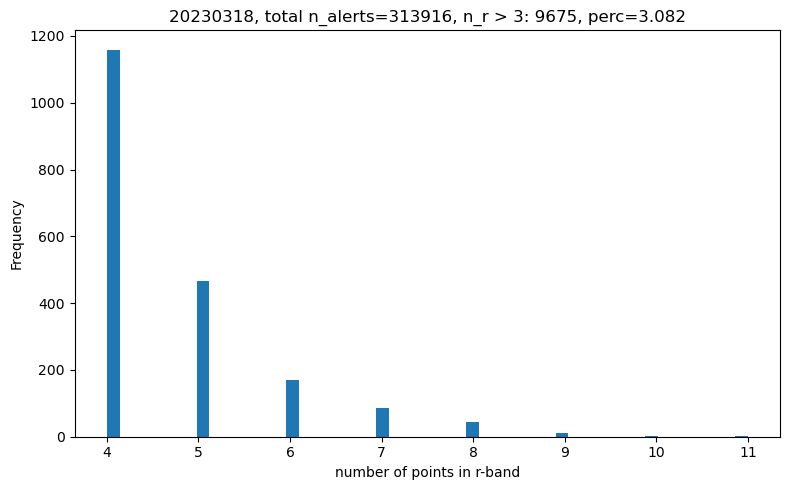

In [15]:
# Convert just the column to Pandas
values = df_r.select("n_rband").sample(False, 0.2, seed=42).toPandas()

# Plot histogram
plt.figure(figsize=(8, 5))
plt.hist(values["n_rband"].dropna(), bins=50)
plt.title(date_to_print + ', total n_alerts=' + str(nobjects) + ', n_r > 3: ' + str(nr) + ', perc='+str(per_rband))
plt.xlabel("number of points in r-band")
plt.ylabel("Frequency")
plt.tight_layout()
plt.savefig(date_to_print + '.png')

In [23]:
df_big = df2.filter(F.col('n_rband')>20)

In [24]:
df_big.count()

126

In [25]:
df_big = df_big.withColumn('jd_gap', F.array_max(F.col("cjd")) - F.array_min(F.col("cjd")))

In [26]:
jd = df_big.select(['cjd_masked','cmagpsf_masked','n_rband']).toPandas()

In [27]:
max(jd['cjd_masked'].values[0]) - min(jd['cjd_masked'].values[0])

24.971041599754244

In [28]:
jd

,cjd_masked,cmagpsf_masked,n_rband
0,"[2459997.0531019, 2459997.0554514, 2459997.057...","[15.3672, 15.368, 15.5, 15.2619, 15.2619, 15.2...",21
1,"[2459997.0531019, 2459997.0554514, 2459997.057...","[15.8954, 15.7613, 15.7734, 15.4818, 15.737, 1...",23
2,"[2460017.0346528, 2460017.0370486, 2460017.039...","[18.6715, 18.6815, 18.6195, 18.5539, 18.1668, ...",23
3,"[2459994.0586227, 2459994.0610532, 2459994.063...","[18.79, 18.8632, 18.8383, 18.8966, 18.9256, 18...",22
4,"[2459997.0531019, 2459997.0554514, 2460017.022...","[16.607, 16.8373, 16.2544, 16.0514, 16.1356, 1...",21
...,...,...,...
121,"[2460017.0346528, 2460017.0370486, 2460017.039...","[17.3477, 17.3345, 17.3169, 17.3413, 17.6436, ...",23
122,"[2460017.0346528, 2460017.0370486, 2460017.039...","[14.5833, 14.5388, 14.593, 14.5516, 14.0225, 1...",21
123,"[2459997.0531019, 2459997.0578241, 2459997.060...","[17.5965, 17.5754, 17.3551, 17.9285, 17.6954, ...",21
124,"[2460017.0346528, 2460017.0370486, 2460017.039...","[18.4633, 18.4736, 18.4688, 18.4362, 18.668, 1...",23


In [29]:
df_big.select('jd_gap').show()

+------------------+
|            jd_gap|
+------------------+
|24.971041599754244|
|24.976134200114757|
| 5.006134200375527|
| 27.96297449991107|
|24.976134200114757|
|27.927430599927902|
| 24.96849530003965|
| 5.003726799972355|
| 5.003726799972355|
|24.965948999859393|
| 27.92696759989485|
| 5.001319400034845|
| 5.005671299993992|
|  24.9735878999345|
|  24.9735878999345|
| 5.001319400034845|
| 5.006134200375527|
| 5.007071699947119|
| 4.998912000097334|
| 5.001319400034845|
+------------------+
only showing top 20 rows



### Filter based on NaNs in the features

In [30]:
struct_col = "lc_features_r"

df3 = df2.filter(F.col(struct_col).isNotNull())

# Build an array with all fields from the struct
vals = F.array(*[F.col(f"{struct_col}.{f.name}")
                 for f in df3.schema[struct_col].dataType.fields])

# Drop rows where ANY value in the struct is NaN
df_clean = df3.filter(~F.exists(vals, lambda v: F.isnan(v)))

In [31]:
df_small = df_clean.filter(F.col('n_rband') < 4)

In [32]:
df_small.count()

0

In [33]:
df_clean.count()

28655